In [1]:
from Data.AnnaDataset import AnnaDataset
from Models.PRNN import PRNN
from Utils.HelperFunctions import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tnrange
import matplotlib.pyplot as plt
import numpy as np
import gc
import os
%matplotlib inline  

# parameters
BATCH_SIZE = 128
N_STEPS = 100
N_INPUTS = 77
N_HIDDEN = 512
N_OUTPUTS = 77
N_EPOCHS = 51
learning_rates = 2**np.arange(1,20,1)*1e-10
N_REPS = len(learning_rates)

# use gpu when possible
mydevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset = AnnaDataset(N_STEPS)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)

In [ ]:
train_loss = np.zeros((N_EPOCHS,N_REPS))
train_acc = np.zeros((N_EPOCHS,N_REPS))

model = [None]*N_REPS
for rep in tnrange(N_REPS):
    model[rep] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,1,mydevice).to(mydevice)
    optimizer = torch.optim.RMSprop(model[rep].parameters(), lr=learning_rates[rep], momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model[rep].train()
    for epoch in tnrange(N_EPOCHS):
        running_train_loss = 0
        running_train_acc = 0
        for i, (x,y_tar) in enumerate(dataloader):
            x, y_tar = x.to(mydevice), y_tar.to(mydevice)
            y_pred, hidden = model[rep](x)
            loss = criterion(y_pred.permute(1,2,0),y_tar)
            loss.backward()
            optimizer.step()
            running_train_loss+=loss.item()
            running_train_acc+=get_accuracy(y_pred.permute(1,2,0), y_tar)
        train_loss[epoch,rep] = running_train_loss/(i+1)
        train_acc[epoch,rep] = running_train_acc/(i+1)

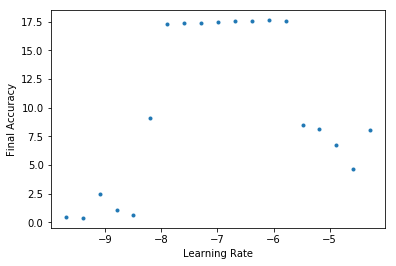

In [102]:
plt.plot(np.log10(learning_rates),train_acc[-1,:],'.')
plt.ylabel('Final Accuracy')
plt.xlabel('Learning Rate')
plt.show()

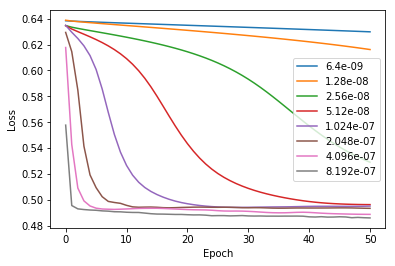

In [101]:
plt.plot(np.log10(train_loss[:,5:-6]))
plt.legend(learning_rates[5:-6])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [99]:
model[10].eval()
x, y_tar = next(iter(dataloader))
y_pred, hidden = model[10](x.to(mydevice))
(torch.max(y_pred.permute(1,2,0), 1)[1].data[1,]==y_tar[1,].to(mydevice)).type(torch.DoubleTensor).mean()

tensor(0.1800, dtype=torch.float64)

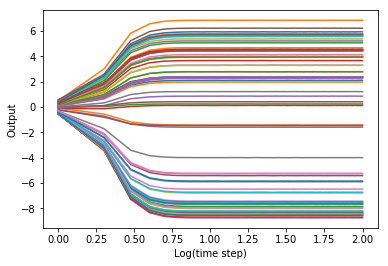

2.048e-07

In [103]:
plt.plot(np.log10(np.arange(1,101)),y_pred.permute(1,2,0).data.cpu().numpy()[0,:,:].T,'-')
plt.ylabel('Output')
plt.xlabel('Log(time step)')
plt.show()
learning_rates[10]

In [105]:
model_path = 'D:\chongguo\git\AM221pset\Project\Final Project\History\Initial_Anna\model_lr_2e_n7.pt'
torch.save(model[10].state_dict(), model_path)